In [80]:
import tensorflow as tf

In [97]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE

In [82]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [83]:
# this part will take images from each directory and convert them to np array and store them in an array

from PIL import Image
import os 
import numpy as np
path1="C:\Abdul Sameer\ICG_CycleGANS\Assgn7\\trainA"
all_imgs=os.listdir(path1)
trainA=[]
trainA_labels=[]
for img in all_imgs:
    img_path = os.path.join(path1, img)
    image = Image.open(img_path)
    image=np.array(image)
    trainA.append(image)
    trainA_labels.append(0)
trainA=np.array(trainA)
trainA_labels=np.array(trainA_labels)

In [84]:
path2="C:\Abdul Sameer\ICG_CycleGANS\Assgn7\\trainB"
all_imgs=os.listdir(path2)
trainB=[]
trainB_labels=[]
for img in all_imgs:
    img_path = os.path.join(path2, img)
    image = Image.open(img_path)
    image=np.array(image)
    trainB.append(image)
    trainB_labels.append(1)
trainB_labels=np.array(trainB_labels)
trainB=np.array(trainB)

In [85]:
path3="C:\Abdul Sameer\ICG_CycleGANS\Assgn7\\testA"
all_imgs=os.listdir(path3)
testA=[]
testA_labels=[]
for img in all_imgs:
    img_path = os.path.join(path3, img)
    image = Image.open(img_path)
    image=np.array(image)
    testA.append(image)
    testA_labels.append(1)
testA_labels=np.array(testA_labels)

testA=np.array(testA)

In [86]:
path4="C:\Abdul Sameer\ICG_CycleGANS\Assgn7\\testB"
all_imgs=os.listdir(path4)
testB=[]
testB_labels=[]
for img in all_imgs:
    img_path = os.path.join(path4, img)
    image = Image.open(img_path)
    image=np.array(image)
    testB.append(image)
    testB_labels.append(1)
testB_labels=np.array(testB_labels)

testB=np.array(testB)

In [87]:
BUFFER_SIZE=1000
BATCH_SIZE=1
img_h=256
img_w=256

In [88]:
# function to crop image randomly
def random_crop(img):
    crop_img = tf.image.random_crop(img,size=[img_h,img_w,3])
    return crop_img

In [89]:
# normalizing images using this function
def normalize(img):
    img = tf.cast(img,tf.float32)
    img = (img/127.5)-1
    return img

In [90]:
def random_jitter(img):
    # converting img into 286x286 using tf method which give better results on images
    img = tf.image.resize(img,[286,286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # again cropping back to 256x256
    img = random_crop(img)
    #mirror image randomly
    img = tf.image.random_flip_left_right(img)
    return img

In [91]:
# using this function in next preprocessing step ,label parameter is required when we use dataset.map()
def prepro_train(img, label):
  img = random_jitter(img)
  img = normalize(img)
  return img

In [92]:
def prepro_test(img, label):
  img = normalize(img)
  return img

In [93]:
trainA = tf.data.Dataset.from_tensor_slices((trainA, trainA_labels))
trainB = tf.data.Dataset.from_tensor_slices((trainB, trainB_labels))
testA = tf.data.Dataset.from_tensor_slices((testA, testA_labels))
testB = tf.data.Dataset.from_tensor_slices((testB, testB_labels))

In [94]:
trainA=trainA.cache().map(prepro_train,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
trainB=trainB.cache().map(prepro_train,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
testA=testA.map(prepro_test,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
testB=testB.map(prepro_test,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


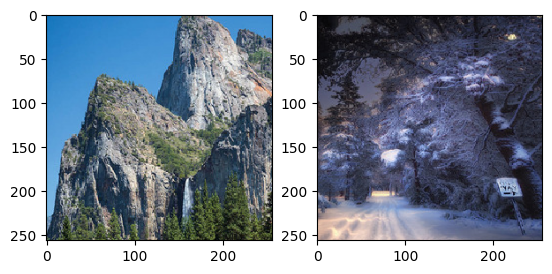

In [129]:
# plotting random images from dataset
sample_summer = next(iter(trainA))
sample_winter = next(iter(trainB))
plt.subplot(121)
plt.imshow(sample_summer[0]*0.5+0.5)

plt.subplot(122)
plt.imshow(sample_winter[0]*0.5+0.5)

In [98]:
OUTPUT_CHANNELS=3
gen_g=pix2pix.unet_generator(OUTPUT_CHANNELS,norm_type='instancenorm')
gen_f=pix2pix.unet_generator(OUTPUT_CHANNELS,norm_type='instancenorm')

disc_x=pix2pix.discriminator(norm_type='instancenorm',target=False)
disc_y=pix2pix.discriminator(norm_type='instancenorm',target=False)

In [100]:
LAMBDA = 10
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [101]:
def disc_loss(real,generated):
    real_loss = loss(tf.ones_like(real),real)
    generated_loss = loss(tf.zeros_like(generated),generated)

    total_loss= real_loss + generated_loss
    return total_loss*0.5

In [102]:
def gen_loss(generated):
    return loss(tf.ones_like(generated),generated)

In [103]:
def cycle_loss(real,cycle):
    loss1=tf.reduce_mean(tf.abs(real-cycle))
    return loss1*LAMBDA

In [108]:
def identity_loss(real,same):
    loss_=tf.reduce_mean(tf.abs(real-same))
    return loss_*LAMBDA*0.5

In [106]:
# defining the optimizers
gen_g_opt=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
gen_f_opt=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

disc_x_opt=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
disc_y_opt=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [107]:
EPOCHS=1


In [109]:
@tf.function
def train_step(real_x,real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = gen_g(real_x,training = True)
        cycled_x = gen_f(fake_y,training = True)

        fake_x = gen_f(real_y,training = True)
        cycled_y = gen_g(fake_x,training = True)

        # these will be used for identity loss
        same_x = gen_g(real_x,training = True)
        same_y = gen_f(real_y,training = True)
        
        disc_real_x = disc_x(real_x,training = True)
        disc_real_y = disc_y(real_y,training = True)

        disc_fake_x = disc_x(fake_x,training = True)
        disc_fake_y = disc_y(fake_y,training = True)

        # for generator we have to check how well it is fooling the discriminator
        # so the loss is 
        gen_g_loss = gen_loss(disc_fake_y)
        gen_f_loss = gen_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x,cycled_x)+cycle_loss(real_y,cycled_y)

        # total generator loss
        
        total_gen_g_loss = gen_g_loss + total_cycle_loss +identity_loss(real_y,same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss +identity_loss(real_x,same_x)

        # calculating discriminator loss
        disc_x_loss = disc_loss(disc_real_x,disc_fake_x)
        disc_y_loss = disc_loss(disc_real_y,disc_fake_y)

        # calculating gradients
        gen_g_grads=tape.gradient(total_gen_g_loss,gen_g.trainable_variables)
        gen_f_grads=tape.gradient(total_gen_f_loss,gen_f.trainable_variables)

        disc_x_grads=tape.gradient(disc_x_loss,disc_x.trainable_variables)
        disc_y_grads=tape.gradient(disc_y_loss,disc_y.trainable_variables)
        
        # applying gradients
        gen_g_opt.apply_gradients(zip(gen_g_grads,gen_g.trainable_variables))
        gen_f_opt.apply_gradients(zip(gen_f_grads,gen_f.trainable_variables))

        disc_x_opt.apply_gradients(zip(disc_x_grads,disc_x.trainable_variables))
        disc_y_opt.apply_gradients(zip(disc_y_grads,disc_y.trainable_variables))


In [110]:
# function to generate images
def gen_imgs(model,input):
    predicted=model(input)

    plt.subplot(121)
    plt.title("Input Image")
    plt.imshow(input[0]*0.5+0.5)
    plt.axis('off')

    plt.subplot(122)
    plt.title("Generated Image")
    plt.axis('off')
    plt.imshow(predicted[0]*0.5+0.5)
    plt.show()

In [131]:
# training here
for epoch in range(EPOCHS):
    start = time.time()
    for img_x,img_y in tf.data.Dataset.zip((trainA,trainB)):
        train_step(img_x,img_y)

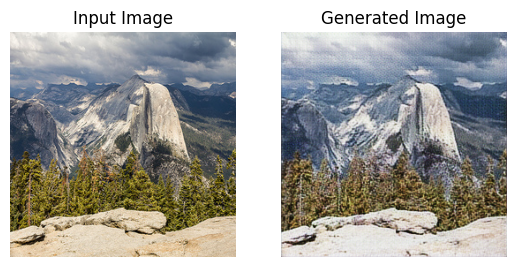

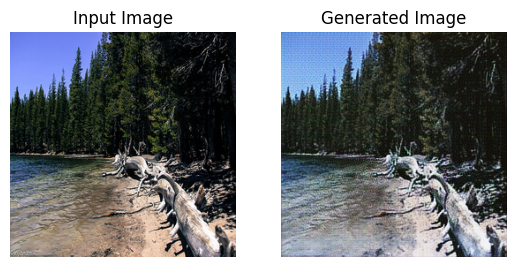

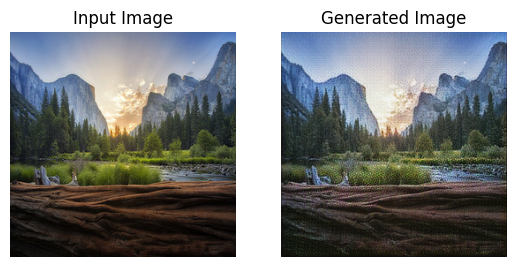

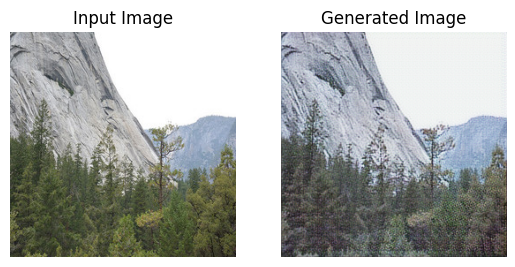

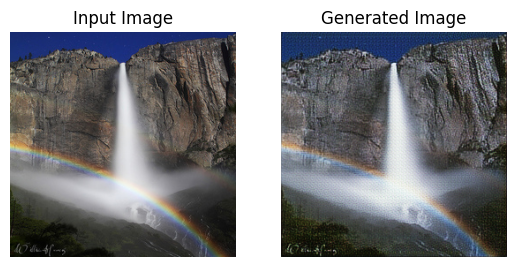

In [127]:
# Run the trained model on the test dataset
for inp in testA.take(5):
  gen_imgs(gen_g, inp)
# A is summer ,B is winter
# generator g translating summer to winter
# generator f translating winter to summer

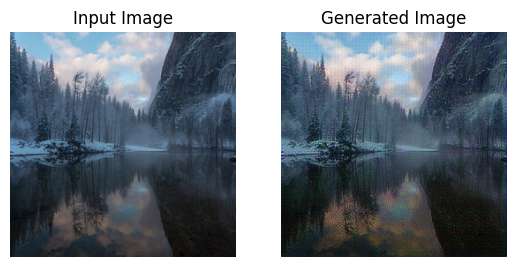

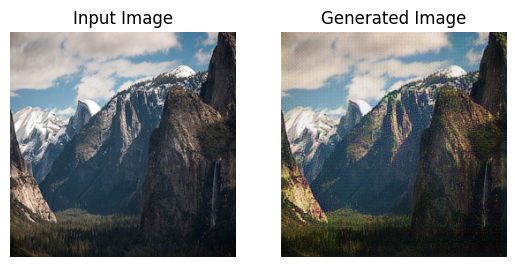

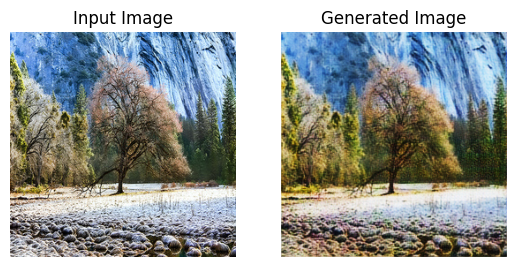

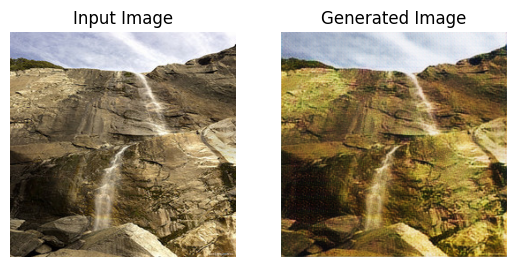

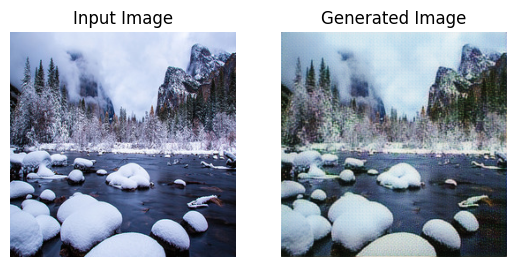

In [128]:
for inp in testB.take(5):
  gen_imgs(gen_f, inp)
  # generator f translating winter to summer